### Estimación de indicadores de energía
Este notebook tiene como objetivo estimar indicadores relacionados con el consumo de energía en la Ciudad de México, utilizando datos de la Encuesta Nacional de Ingresos y Gastos de los Hogares (ENIGH), CONAPO y Secretaría de Energía (SENER). 

Los indicadores elaborados con la ENIGH tienen como objetivo medir el porcentaje de viviendas que cuentan con elementos de energía renovable; es decir, energía solar (paneles y calentadores solares).


Los indicadores elaborados con los datos de la SENER y CONAPO pretenden medir el peso del consumo eléctrico en la economía y el consumo por persona en la Ciudad de México.

In [1]:
##Estimación de indicadores de energia
#Se borra todo lo que se encuentra en el entorno

rm(list=ls())

# Librerías ====
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse, showtext, srvyr,archive)
remotes::install_github("cpyp-ipdp/funcionespgd", force = TRUE)
library(funcionespgd)
font_add_google("Poppins", "pop")
showtext_auto()

Cargando paquete requerido: pacman

Using GitHub PAT from the git credential store.




rlang    (1.1.4 -> 1.1.6) [CRAN]
glue     (1.7.0 -> 1.8.0) [CRAN]
cli      (3.6.3 -> 3.6.5) [CRAN]
magrittr (2.0.3 -> 2.0.4) [CRAN]
tibble   (3.2.1 -> 3.3.0) [CRAN]
ggplot2  (3.5.2 -> 4.0.0) [CRAN]


Installing 6 packages: rlang, glue, cli, magrittr, tibble, ggplot2

Warning message:
"packages 'tibble', 'ggplot2' are in use and will not be installed"
Installing packages into 'C:/Users/claud/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



package 'rlang' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'rlang'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\rlang\libs\x64\rlang.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\rlang\libs\x64\rlang.dll: Permission denied"
Warning message:
"restored 'rlang'"


package 'glue' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'glue'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\glue\libs\x64\glue.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\glue\libs\x64\glue.dll: Permission denied"
Warning message:
"restored 'glue'"


package 'cli' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'cli'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\cli\libs\x64\cli.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\cli\libs\x64\cli.dll: Permission denied"
Warning message:
"restored 'cli'"


package 'magrittr' successfully unpacked and MD5 sums checked


Warning message:
"cannot remove prior installation of package 'magrittr'"
Warning message in file.copy(savedcopy, lib, recursive = TRUE):
"problema al copiar C:\Users\claud\AppData\Local\R\win-library\4.4\00LOCK\magrittr\libs\x64\magrittr.dll  a C:\Users\claud\AppData\Local\R\win-library\4.4\magrittr\libs\x64\magrittr.dll: Permission denied"
Warning message:
"restored 'magrittr'"



The downloaded binary packages are in
	C:\Users\claud\AppData\Local\Temp\RtmpqsWKEC\downloaded_packages
── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file 'C:\Users\claud\AppData\Local\Temp\RtmpqsWKEC\remotese6c54d2141f\cpyp-ipdp-funcionespgd-6fd64b9/DESCRIPTION' ... OK
* preparing 'funcionespgd':
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
Omitted 'LazyData' from DESCRIPTION
* building 'funcionespgd_0.1.0.tar.gz'



Installing package into 'C:/Users/claud/AppData/Local/R/win-library/4.4'
(as 'lib' is unspecified)



### Descarga ENIGH

In [2]:
#Crear directorio para guardar los archivos
dir.create("data", showWarnings = FALSE)

In [3]:
url_basica<-"https://www.inegi.org.mx/contenidos/programas/enigh/nc/"
segunda_parte<-"microdatos/enigh"
fin<-"_ns_viviendas_csv.zip"

In [4]:
years<-c("2016", "2018", "2020", "2022","2024")

In [5]:
# Descargar los archivos, descomprimirlos y renombrarlos
for (i in 1:length(years)) {
  url <- paste0(url_basica, years[i], "/", segunda_parte, years[i], fin)
  destfile <- paste0("data/", years[i], fin)

  # Descargar el archivo
  download.file(url, destfile = destfile)

  # Descomprimir el archivo
  unzip(destfile, exdir = "data")

  # Renombrar el archivo descomprimido a "viviendas_xxxx.csv"
  file.rename(
    from = "data/viviendas.csv",
    to = paste0("data/viviendas_", years[i], ".csv")
  )
}

In [6]:
#Enlistar archivos de la carpeta data
list.files("data")

[1] "2016_ns_viviendas_csv.zip"         "2018_ns_viviendas_csv.zip"        
 [3] "2020_ns_viviendas_csv.zip"         "2022_ns_viviendas_csv.zip"        
 [5] "2024_ns_viviendas_csv.zip"         "nota_bases_datos_enigh2016_ns.txt"
 [7] "nota_bases_datos_enigh2018_ns.txt" "viviendas_2016.csv"               
 [9] "viviendas_2018.csv"                "viviendas_2020.csv"               
[11] "viviendas_2022.csv"                "viviendas_2024.csv"

#### Construcción de función de estimación de indicadores de páneles y calentadores solares

In [7]:
estimacion <- function(path, variable) {
  # Cargar los datos
  print(path)
  datos <- read_csv(path)

  datos <- datos %>%
    mutate(
      across(starts_with("mat") & where(is.character),
             ~ replace_na(parse_number(.x, na = c('', 'NA', '&')), 0))) %>%
    mutate(cve_ent = case_when(
      nchar(folioviv) == 9  ~ paste0("0", substr(folioviv, 1, 1)),
      nchar(folioviv) == 10 ~ substr(folioviv, 1, 2)
    ))


  # Definir diseño muestral
  mydesign <- datos %>%
    as_survey_design(ids = upm,
                     strata = est_dis,
                     weights = factor)




  # Devolver el resultado basado en la variable
  resultado<-if (variable == "paneles_solares") {
      mydesign %>%
        filter(cve_ent=="09")%>%
        group_by(disp_elect)%>%
        summarise(viviendas = survey_total(vartype = "cv"),
                  pct = survey_prop(vartype = "cv")) %>%
        mutate(pct = round(pct * 100, 2),
        year = substr(path, 16, 19)) %>%
                  filter(disp_elect==3)
      
    } else if (variable == "calentador_solar") {
        
        mydesign %>%
            filter(cve_ent=="09") %>%
        group_by(calent_sol) %>%
        summarise(
          viviendas = survey_total(vartype = "cv"),
          pct = survey_prop(vartype = "cv")
        ) %>%
        mutate(pct = round(pct * 100, 2),
        year = substr(path, 16, 19))%>%
        filter(calent_sol ==1)
    } 
    else {
        stop("Variable no reconocida")

    }
    return (resultado)
}


In [8]:
#Páneles solares
tabla_paneles<-map_dfr(
  list.files("data", full.names = TRUE, pattern = "viviendas_.*.csv"),
  
  estimacion,
  variable = "paneles_solares"
)%>%
mutate(year = as.integer(year))
print("Porcentaje de viviendas cuya fuente de energía eléctrica es paneles solares")
tabla_paneles

[1] "data/viviendas_2016.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 69169 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (54): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2018.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 73405 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2020.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 87754 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2022.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 88823 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2024.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 90324 Columns: 82
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): folioviv, mat_techos, finan_8, num_dueno1, num_dueno2, ubica_geo, ...
dbl (74): tipo_viv, mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, co...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Porcentaje de viviendas cuya fuente de energía eléctrica es paneles solares"


disp_elect,viviendas,viviendas_cv,pct,pct_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
3,1413,0.9824665,0.05,0.9830007,2018
3,1456,0.9897514,0.05,0.9891532,2020
3,3897,0.7306537,0.13,0.7304977,2022
3,1796,0.9461860,0.06,0.9457396,2024


In [9]:
#Calentadores solares
tabla_calentadores<-map_dfr(
  list.files("data", full.names = TRUE, pattern = "viviendas_.*.csv"),
  
  estimacion,
  variable = "calentador_solar"
)%>%
mutate(year = as.integer(year))
print("Porcentaje de viviendas que cuentan con calentador solar")
tabla_calentadores

[1] "data/viviendas_2016.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 69169 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (54): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2018.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 73405 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2020.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 87754 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2022.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 88823 Columns: 64
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (9): folioviv, tipo_viv, mat_techos, tipo_finan, num_dueno1, num_dueno2...
dbl (55): mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, cocina_dor, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "data/viviendas_2024.csv"


Warning message:
"One or more parsing issues, call `problems()` on your data frame for details,
e.g.:
  dat <- vroom(...)
  problems(dat)"
Rows: 90324 Columns: 82
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (8): folioviv, mat_techos, finan_8, num_dueno1, num_dueno2, ubica_geo, ...
dbl (74): tipo_viv, mat_pared, mat_pisos, antiguedad, antigua_ne, cocina, co...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] "Porcentaje de viviendas que cuentan con calentador solar"


calent_sol,viviendas,viviendas_cv,pct,pct_cv,year
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
1,91071,0.14404422,3.28,0.14380862,2016
1,138346,0.12063960,5.08,0.12061981,2018
1,171010,0.09928719,6.32,0.09913734,2020
1,284406,0.08872492,9.65,0.08507572,2022
1,286208,0.08628527,9.45,0.08590141,2024


#### Indicadores de consumo eléctrico per cápita y peso del consumo eléctrico en la economía

In [10]:
##Leer PIB CDMX

urlpib<-"https://www.inegi.org.mx/contenidos/programas/pibent/2018/tabulados/ori/PIBE_57.xlsx"

In [11]:
#Descarga en temporal y lectura

temp <- tempfile(fileext = ".xlsx")
download.file(urlpib, temp, mode = "wb")
pib_cdmx <- readxl::read_excel(temp)%>%
#Seleccionar fila 4 y 6
    slice(c(4,6))%>%
  mutate(r = row_number()) %>%                    # 1 = year, 2 = pib
  pivot_longer(-r, values_to = "v") %>%
  pivot_wider(names_from = r, values_from = v, names_prefix = "r") %>%
  #Eliminar letras de los años
  mutate(
    r1 = str_remove_all(r1, "[^0-9]"),
    r2 = str_remove_all(r2, "[^0-9\\.]")
  )%>%
  transmute(
    year = parse_integer(r1),
    pib  = parse_number(r2)
  )%>%
#Eliminar primera fila
  slice(-1)

pib_cdmx

New names:
• `` -> `...2`
• `` -> `...3`
• `` -> `...4`
• `` -> `...5`
• `` -> `...6`
• `` -> `...7`
• `` -> `...8`
• `` -> `...9`
• `` -> `...10`
• `` -> `...11`
• `` -> `...12`
• `` -> `...13`
• `` -> `...14`
• `` -> `...15`
• `` -> `...16`
• `` -> `...17`
• `` -> `...18`
• `` -> `...19`
• `` -> `...20`
• `` -> `...21`
• `` -> `...22`


year,pib
<int>,<dbl>
2003,2842789
2004,2962342
2005,2991075
2006,3134225
2007,3142464
2008,3183429
2009,3008812
2010,3125717
2011,3231440


In [12]:
consumo_energia<-openxlsx::read.xlsx("consumo_elect.xlsx")%>%
janitor::clean_names()%>%
#Eliminar espacios adelante y atrás de entidad_federativa
mutate(entidad_federativa = str_trim(entidad_federativa, side = "both"))%>%
filter(entidad_federativa=="Ciudad de México")%>%
pivot_longer(-entidad_federativa, names_to = "year", values_to = "consumo")%>%
#Elimnar "x" de los años
mutate(year = str_remove_all(year, "x"))%>%
#Convertir year a integer y consumo a numeric
mutate(
  year = as.integer(year),
  consumo = as.numeric(consumo)
)%>%
#consumo a de gigawats a kilowatts
mutate(consumo = consumo * 1000000)
consumo_energia

entidad_federativa,year,consumo
<chr>,<int>,<dbl>
Ciudad de México,2009,14036800000
Ciudad de México,2010,13287300000
Ciudad de México,2011,13667100000
Ciudad de México,2012,14129200000
Ciudad de México,2013,14563000000
Ciudad de México,2014,14300600000
Ciudad de México,2015,14464300000
Ciudad de México,2016,14500000000
Ciudad de México,2017,13621700000


#### Intensidad energética

In [13]:
intensidad_energetica<-consumo_energia%>%
#Pegar con pib_cdmx
left_join(pib_cdmx, by = "year")%>%
#Calcular intensidad energética
mutate(intensidad_energetica = consumo / pib)%>%
#Eliminar nans
filter(!is.na(intensidad_energetica))
intensidad_energetica

entidad_federativa,year,consumo,pib,intensidad_energetica
<chr>,<int>,<dbl>,<dbl>,<dbl>
Ciudad de México,2009,14036800000,3008812,4665.230
Ciudad de México,2010,13287300000,3125717,4250.961
Ciudad de México,2011,13667100000,3231440,4229.414
Ciudad de México,2012,14129200000,3332209,4240.191
Ciudad de México,2013,14563000000,3363394,4329.852
Ciudad de México,2014,14300600000,3412110,4191.131
Ciudad de México,2015,14464300000,3503520,4128.505
Ciudad de México,2016,14500000000,3571368,4060.069
Ciudad de México,2017,13621700000,3646318,3735.741


#### Consumo eléctrico per cápita

In [68]:
consumo_percap<-read_csv("https://conapo.segob.gob.mx/work/models/CONAPO/Datos_Abiertos/pry23/00_Pob_Mitad_1950_2070.csv")%>%
janitor::clean_names()%>%
filter(cve_geo==9)%>%
rename(year=ano)%>%
group_by(year)%>%
summarise(poblacion=sum(poblacion))%>%
left_join(consumo_energia, by = "year")%>%
#Calcular consumo per cápita
mutate(consumo_percapita = consumo / poblacion)%>%
filter(!is.na(consumo_percapita))%>%
filter(year<2024)

consumo_percap

Rows: 737660 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (2): ENTIDAD, SEXO
dbl (5): RENGLON, AÑO, CVE_GEO, EDAD, POBLACION

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


year,poblacion,entidad_federativa,consumo,consumo_percapita
<dbl>,<dbl>,<chr>,<dbl>,<dbl>
2009,9029228,Ciudad de México,14036800000,1554.596
2010,9044151,Ciudad de México,13287300000,1469.159
2011,9074286,Ciudad de México,13667100000,1506.135
2012,9102171,Ciudad de México,14129200000,1552.289
2013,9121489,Ciudad de México,14563000000,1596.560
2014,9131261,Ciudad de México,14300600000,1566.114
2015,9152227,Ciudad de México,14464300000,1580.413
2016,9196836,Ciudad de México,14500000000,1576.629
2017,9246758,Ciudad de México,13621700000,1473.133


#### Proyecciones

In [15]:
#indicador páneles


tcma_paneles<-((tabla_paneles$pct[tabla_paneles$year==2024]/tabla_paneles$pct[tabla_paneles$year==2018])^(1/(2024-2018))-1)

tcma_paneles

[1] 0.03085332

In [18]:
extendido_paneles<-data.frame(year=2025:2045)
extendido_paneles$pct<-tabla_paneles$pct[tabla_paneles$year==2024]*cumprod(rep(1+tcma_paneles,length(2025:2045)))
extendido_paneles%>%
mutate(pct=round(pct,2))

year,pct
<int>,<dbl>
2025,0.06
2026,0.06
2027,0.07
2028,0.07
2029,0.07
2030,0.07
2031,0.07
2032,0.08
2033,0.08


In [19]:
  serie_completa_paneles <- bind_rows(
    tabla_paneles %>%
      dplyr::mutate(year = as.numeric(year)) %>%
      intervals(margen = 0, año_base = 2024,var = "pct"),

    extendido_paneles %>%
      dplyr::mutate(year = as.numeric(year)) %>%
      intervals(margen = 0.004, año_base = 2024,var="pct"))
serie_completa_paneles

year,estimado,superior,inferior
<dbl>,<dbl>,<dbl>,<dbl>
2018,0.05000000,0.05000000,0.05000000
2020,0.05000000,0.05000000,0.05000000
2022,0.13000000,0.13000000,0.13000000
2024,0.06000000,0.06000000,0.06000000
2025,0.06185120,0.06209860,0.06160478
2026,0.06375951,0.06427061,0.06325248
2027,0.06572671,0.06651859,0.06494425
2028,0.06775459,0.06884519,0.06668128
2029,0.06984505,0.07125317,0.06846475


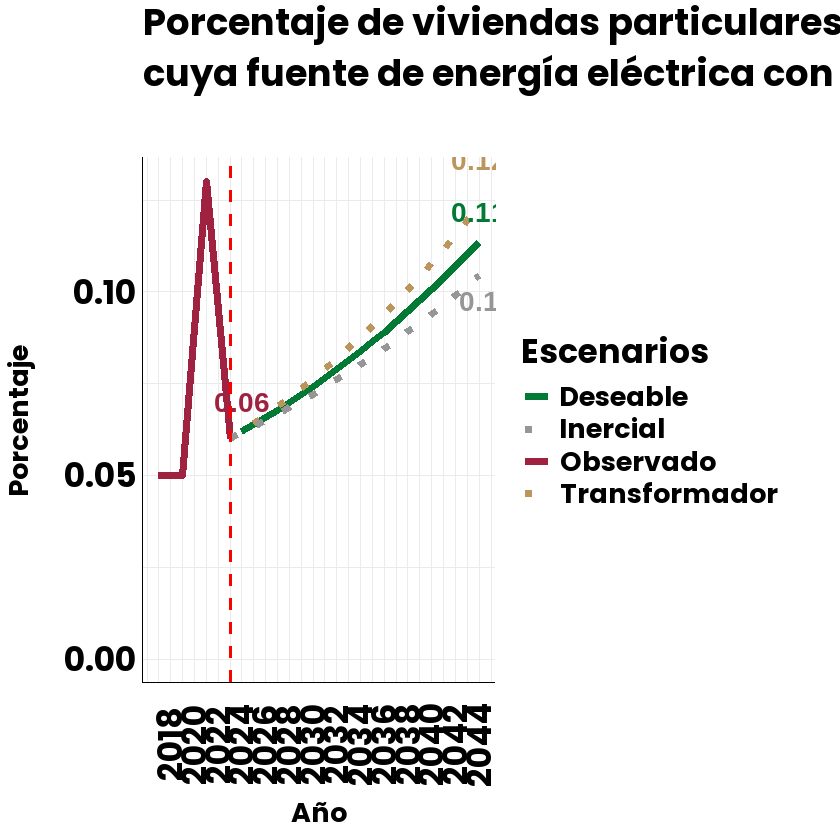

In [ ]:
grafica_bonita(
  data = serie_completa_paneles,
  x = "year",
  y = "estimado",
  titulo = "Porcentaje de viviendas particulares habitadas 
cuya fuente de energía eléctrica con paneles solares en la Ciudad de México
",
    ano_base = 2024,
  mostrar_etiqueta_ano_base = TRUE,
  linea_vertical = 2024,
  anios_etiquetas = c(2045),
  desplazamiento_ano_base=c(1, 0.01),
  mostrar_intervalo = "ambos",
  nombre_observado = "Observado",
  nombre_estimado_futuro = "Deseable",
  nombre_intervalo_superior = "Transformador",
  nombre_intervalo_inferior = "Inercial",
  mostrar_leyenda = TRUE,
  fuente = "pop",
  etiqueta_x = "Año",
  etiqueta_y = "Porcentaje",
  titulo_leyenda = "Escenarios",
  limite_inferior_y = 0
)

ggsave("H:/Mi unidad/pgd/graficas/energia/pct_viv_paneles_solares.png",
 width = 10, height = 8.5, dpi = 185, bg = "white")

In [35]:
## Indicador calentadores solares
tcma_calentadores<-((tabla_calentadores$pct[tabla_calentadores$year==2024]/tabla_calentadores$pct[tabla_calentadores$year==2020])^(1/(2024-2020))-1)

tcma_calentadores

[1] 0.1058053

In [36]:
extendido_calentadores<-data.frame(year=2025:2045)
extendido_calentadores$pct<-tabla_calentadores$pct[tabla_calentadores$year==2024]*cumprod(rep(1+tcma_paneles,length(2025:2045)))
extendido_calentadores%>%
mutate(pct=round(pct,2))

year,pct
<int>,<dbl>
2025,9.74
2026,10.04
2027,10.35
2028,10.67
2029,11.00
2030,11.34
2031,11.69
2032,12.05
2033,12.42


In [37]:
  serie_completa_calentadores <- bind_rows(
    tabla_calentadores %>%
      dplyr::mutate(year = as.numeric(year)) %>%
      intervals(margen = 0, año_base = 2024,var = "pct"),

    extendido_calentadores %>%
      dplyr::mutate(year = as.numeric(year)) %>%
      intervals(margen = 0.004, año_base = 2024,var="pct"))
serie_completa_calentadores

year,estimado,superior,inferior
<dbl>,<dbl>,<dbl>,<dbl>
2016,3.280000,3.28000,3.280000
2018,5.080000,5.08000,5.080000
2020,6.320000,6.32000,6.320000
2022,9.650000,9.65000,9.650000
2024,9.450000,9.45000,9.450000
2025,9.741564,9.78053,9.702753
2026,10.042123,10.12262,9.962266
2027,10.351956,10.47668,10.228720
2028,10.671349,10.84312,10.502301


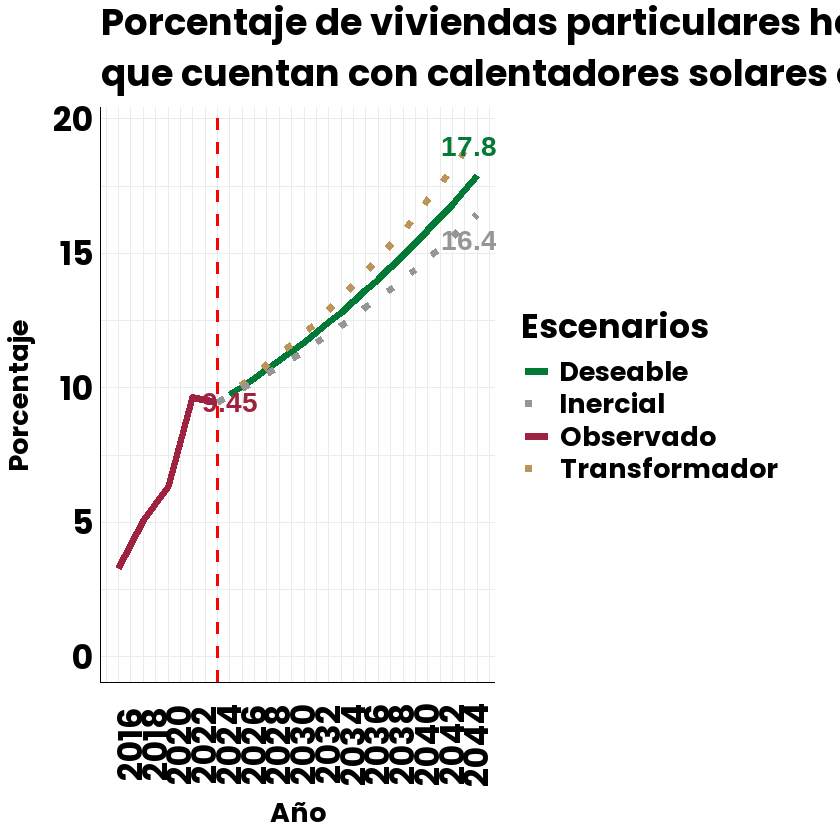

In [ ]:
grafica_bonita(
  data = serie_completa_calentadores,
  x = "year",
  y = "estimado",
  titulo = "Porcentaje de viviendas particulares habitadas 
que cuentan con calentadores solares en la Ciudad de México",
    ano_base = 2024,
  mostrar_etiqueta_ano_base = TRUE,
  linea_vertical = 2024,
  anios_etiquetas = c(2045),
  desplazamiento_ano_base=c(1, 0.01),
  mostrar_intervalo = "ambos",
  nombre_observado = "Observado",
  nombre_estimado_futuro = "Deseable",
  nombre_intervalo_superior = "Transformador",
  nombre_intervalo_inferior = "Inercial",
  mostrar_leyenda = TRUE,
  fuente = "pop",
  etiqueta_x = "Año",
  etiqueta_y = "Porcentaje",
  titulo_leyenda = "Escenarios",
  limite_inferior_y = 0
)

ggsave("H:/Mi unidad/pgd/graficas/energia/pct_viv_calentadores_solares.png",
 width = 10, height = 8.5, dpi = 185, bg = "white")

In [42]:
tcma_intensidad<-((intensidad_energetica$intensidad_energetica[intensidad_energetica$year==2023]/intensidad_energetica$intensidad_energetica[intensidad_energetica$year==2013])^(1/(2023-2013))-1)


tcma_intensidad

[1] -0.02981294

In [ ]:
extendido_intensidad<-data.frame(year=2024:2045)
extendido_intensidad$intensidad_energetica<-intensidad_energetica$intensidad_energetica[intensidad_energetica$year==2023]*cumprod(rep(1+tcma_intensidad,length(2024:2045)))
extendido_intensidad%>%
mutate(intensidad_energetica=round(intensidad_energetica,2))

year,intensidad_energetica
<int>,<dbl>
2024,3103.73
2025,3011.19
2026,2921.42
2027,2834.33
2028,2749.83
2029,2667.85
2030,2588.31
2031,2511.14
2032,2436.28


In [47]:
  serie_completa_intensidad <- bind_rows(
    intensidad_energetica %>%
      dplyr::mutate(year = as.numeric(year)) %>%
      intervals(margen = 0, año_base = 2023,var = "intensidad_energetica"),
    extendido_intensidad %>%
      dplyr::mutate(year = as.numeric(year)) %>%
      intervals(margen = 0.004, año_base = 2023,var="intensidad_energetica"))
serie_completa_intensidad

year,estimado,superior,inferior
<dbl>,<dbl>,<dbl>,<dbl>
2009,4665.230,4665.230,4665.230
2010,4250.961,4250.961,4250.961
2011,4229.414,4229.414,4229.414
2012,4240.191,4240.191,4240.191
2013,4329.852,4329.852,4329.852
2014,4191.131,4191.131,4191.131
2015,4128.505,4128.505,4128.505
2016,4060.069,4060.069,4060.069
2017,3735.741,3735.741,3735.741


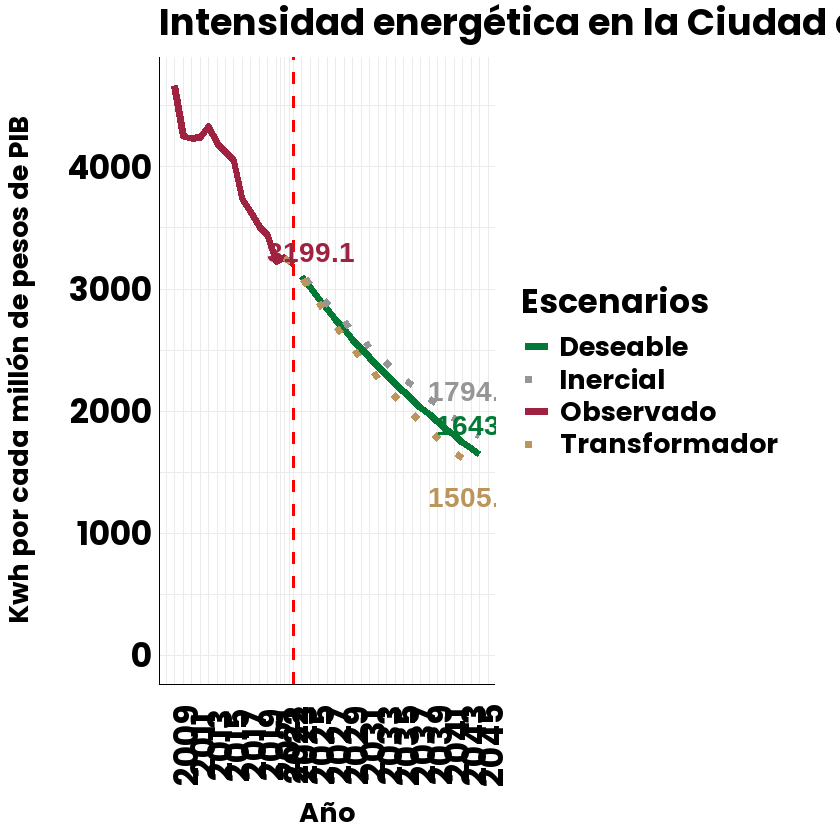

In [66]:
grafica_bonita(
  data = serie_completa_intensidad,
  x = "year",
  y = "estimado",
  titulo = "Intensidad energética en la Ciudad de México",
    ano_base = 2023,
  mostrar_etiqueta_ano_base = TRUE,
  linea_vertical = 2023,
  anios_etiquetas = c(2045),
  desplazamiento_ano_base=c(2, 100),
  mostrar_intervalo = "ambos",
  nombre_observado = "Observado",
  nombre_estimado_futuro = "Deseable",
  nombre_intervalo_superior = "Inercial",
  nombre_intervalo_inferior = "Transformador",
  mostrar_leyenda = TRUE,
  fuente = "pop",
  etiqueta_x = "Año",
  etiqueta_y = "Kwh por cada millón de pesos de PIB",
  titulo_leyenda = "Escenarios",
  limite_inferior_y = 0
)

ggsave("H:/Mi unidad/pgd/graficas/energia/intensidad_energetica.png",
 width = 10, height = 8.5, dpi = 185, bg = "white")


In [69]:
## Indicador consumo per cápita
tcma_consumo<-((consumo_percap$consumo_percapita[consumo_percap$year==2023]/consumo_percap$consumo_percapita[consumo_percap$year==2013])^(1/(2023-2013))-1)

tcma_consumo

[1] -0.01881363

In [70]:
extendido_consumo<-data.frame(year=2024:2045)
extendido_consumo$consumo_percapita<-consumo_percap$consumo_percapita[consumo_percap$year==2023]*cumprod(rep(1+tcma_consumo,length(2024:2045)))
extendido_consumo%>%
mutate(consumo_percapita=round(consumo_percapita,2))

year,consumo_percapita
<int>,<dbl>
2024,1295.54
2025,1271.17
2026,1247.25
2027,1223.79
2028,1200.76
2029,1178.17
2030,1156.01
2031,1134.26
2032,1112.92


In [72]:
  serie_completa_consumo <- bind_rows(
    consumo_percap %>%
      dplyr::mutate(year = as.numeric(year)) %>%
      intervals(margen = 0, año_base = 2023,var = "consumo_percapita"),
    extendido_consumo %>%
      dplyr::mutate(year = as.numeric(year)) %>%
      intervals(margen = 0.004, año_base = 2023,var="consumo_percapita"))
serie_completa_consumo

year,estimado,superior,inferior
<dbl>,<dbl>,<dbl>,<dbl>
2009,1554.5958,1554.5958,1554.5958
2010,1469.1595,1469.1595,1469.1595
2011,1506.1350,1506.1350,1506.1350
2012,1552.2890,1552.2890,1552.2890
2013,1596.5595,1596.5595,1596.5595
2014,1566.1145,1566.1145,1566.1145
2015,1580.4132,1580.4132,1580.4132
2016,1576.6292,1576.6292,1576.6292
2017,1473.1325,1473.1325,1473.1325


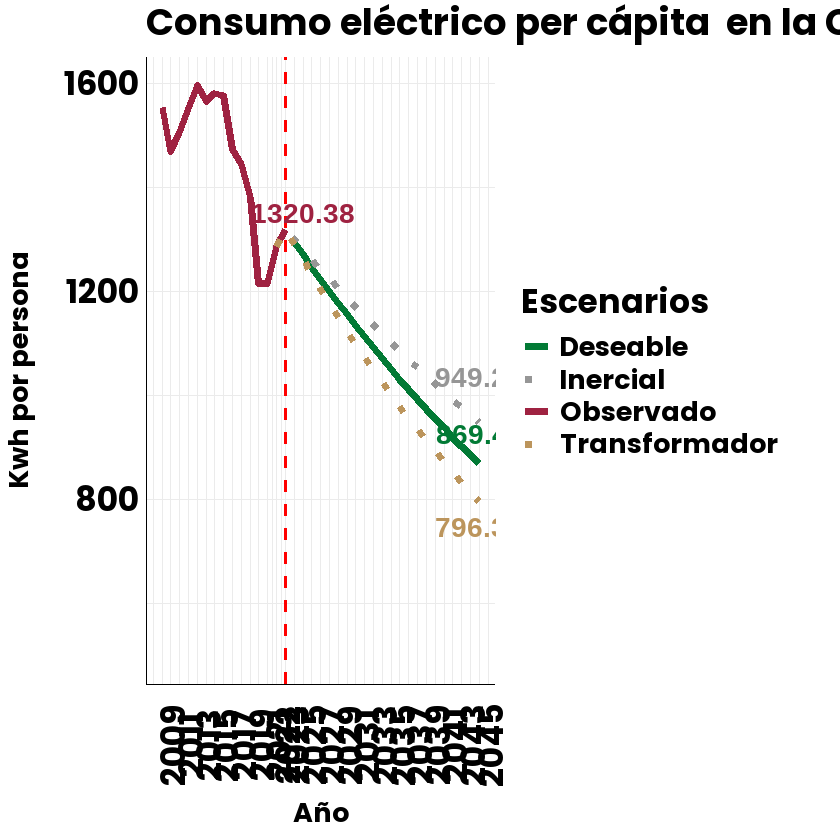

In [77]:
grafica_bonita(
  data = serie_completa_consumo,
  x = "year",
  y = "estimado",
  titulo = "Consumo eléctrico per cápita  en la Ciudad de México",
    ano_base = 2023,
  mostrar_etiqueta_ano_base = TRUE,
  linea_vertical = 2023,
  anios_etiquetas = c(2045),
  desplazamiento_ano_base=c(2, 30),
  mostrar_intervalo = "ambos",
  nombre_observado = "Observado",
  nombre_estimado_futuro = "Deseable",
  nombre_intervalo_superior = "Inercial",
  nombre_intervalo_inferior = "Transformador",
  mostrar_leyenda = TRUE,
  fuente = "pop",
  etiqueta_x = "Año",
  etiqueta_y = "Kwh por persona",
  titulo_leyenda = "Escenarios",
  limite_inferior_y = 500
)

ggsave("H:/Mi unidad/pgd/graficas/energia/consumo_percapita.png",
 width = 10, height = 8.5, dpi = 185, bg = "white")